## Methods for Detecting SST Structures: Fronts and Filaments
### *Using 1D Cruise tracks*

This script will walk through the methodolgies described for the detection of fronts and filaments using 1D tracks of SST. The script is broken into two parts, the first being filaments and the second front methods. At the end, additional plots are generated for the ensembles of each respective set as well as investigation into fluorometry data.  

In [2]:
# --------- Edit Code --------- #

# Detection Parameters #
window_size = 25 # Multiply by 10 for physical distance of smoothing relative to track
gradient_thresh = 1.0 # in deg. C per KM

# General Graphing Params #
fs_tick = 25
fs_label = 30
fs_title = 40

# Other #
individual_cruise_ensemble = False
dates = ['280415']
#dates = ['20180305']
saveplots = True

#### Library Import

In [7]:
# ----- Import Libraries ----- #

# Functions
import numpy as np
import revisedZodiacFunctions as zf

# Files
import pickle

# Plotting
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
from matplotlib.collections import LineCollection
from matplotlib import cm
from matplotlib import colors
import matplotlib as mlb
from matplotlib import colors
from matplotlib.colors import LogNorm
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize, LogNorm, NoNorm
import matplotlib.patches as mpatches
import matplotlib.axes as AX
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
#from matplotlib.axes import inset_axes

# Mapping
import cartopy
import cartopy.crs as ccrs #importing the cartopy coordinate reference system library
import cartopy.feature as cfeature #importing the cartopy library of surface features
import cartopy.io.shapereader as shpreader

# Smoothing
import scipy.io as sio
import scipy.stats as ss
from scipy import signal
from scipy.signal import find_peaks
from scipy.signal import peak_prominences

In [9]:
# --------- DONT EDIT Code --------- #
if individual_cruise_ensemble == True:
    normalize_ensembles = False
else:
    normalize_ensembles = True
    dates = []

### Generating Ensembles 
Before ensembles are made, the necessary pickle files that contain all relevant data from the Zodiac must be imported. Additionally, to sort through the data, organized by date, an array of all possible dates from the 2015-2023 span is made for automated indexing of cruise tracks. The decision for doing ensembles for individual cruises is ALSO possible! 

In [11]:
# ----- IMPORT Track dictionary as pkl ----- #
# Read dictionary pkl file
with open('track_data.pkl', 'rb') as ztd:
    zodiac_track_data = pickle.load(ztd)
    
# CHECK - uncomment to view all cruises #
#zodiac_track_data

# ----- Create array of dates ----- #
# These strings will be used to generate the subsequent array which holds all of our dates to run through when collating 
# ALL of the Zodiac data 
# year_strings = ['15', '16', '17', '2017', '2018', '2019', '2020', '2021', '2022', '2023']
# month_strings = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'] 
# day_strings = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10',
#                  '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', 
#                  '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']

# # Compile all possible dates #
# if individual_cruise_ensemble == False:
#     for y in range(len(year_strings)):
#         year = year_strings[y]
#         for m in range(len(month_strings)):
#             month = month_strings[m]
#             for d in range(len(day_strings)):
#                 day = day_strings[d]
#                 # Before we are done with 2017 - year[3] - we must swicth the way in which we label the date as this when 
#                 # the means of recording cruise date switched from the two forms seen below 
#                 if y < 3:
#                     date = day+month+year
#                 else:
#                     date = year+month+day
#                 dates = np.append(dates, date)

#### Filaments 
We first generate the ensemble of detected filaments as these are structures with gradients on both sides of a clear local SST minima. Therefore it can be said that there are fronts within filaments. So filaments are found first with their GPS positions to compare to the positions of fronts in the next ensemble, removing any matching structures! 

In [13]:
# Arrays to fill #
failed_dates   = [] # List of dates Zodiac did not leave
zero_grad      = [] # indices of where a sst local max and min resides 

# Arrays for Data Analysis # 
filament_width = []
symmetry       = []

# Ensemble of ALL filaments #
filament_ensemble = {}

# Needed values #
compass_range=np.arange(180, 361, 1)
compass_range = np.append(compass_range, compass_range[::-1])

# This master loop is simply to go through each possible date the zodiac went out, and grab corresponding data 
num = 0 # For counting fronts for our ensemble
for index, date in enumerate(zodiac_track_data):
    try:
        # FUNCTION WILL GRAB DICTIONARY WITH CORREPSONDING DATE AND REMOVE NANS AS WELL AS ENSURE DATA IS IN DEFINED BOUNDS OF SMB - EXCLUDING MARINA
        specific_track, lat, lon, SST, flu = zf.track_selector(date, zodiac_track_data, excludenans=True, excludemdr=True)
        # Data Processing, Filtering, & Gradients for SST #
        dist_processed, sst_processed = zf.data_processing(lat, lon, SST, 10)
        grad_dist_sst, grad_sst, lat_sst, lon_sst, sst_filtered, dist_filtered = \
        zf.running_avg_filter(window_size, lat, lon, sst_processed, dist_processed)
        # Data Processing, Filtering, & Gradients for Flu #
        dist_processed, flu_processed = zf.data_processing(lat, lon, flu, 10)
        grad_dist_flu, grad_flu, grad_lat_flu, grad_lon_flu, flu_filtered, dist_filtered = \
        zf.running_avg_filter(window_size, lat, lon, flu_processed, dist_processed)
    except:
        failed_dates = np.append(failed_dates, date)
        pass
    # Get final details on cruise path - Bearing (Direction of boat)
    bearing = np.around(zf.bearing(lat_sst, lon_sst), 2)
    # split this into components (vector form)
    lon_comp = 1*np.sin(np.around(bearing, 0)*(np.pi/180))
    lat_comp = 1*np.cos(np.around(bearing, 0)*(np.pi/180))
                    
    # Find the local SST minimum and maximums #
    sst_loc_max, _ = find_peaks(sst_filtered, height=0) # READ ABOUT FIND PEAKS ####
    sst_loc_min, _ = find_peaks(-1*sst_filtered, height = -30)
    zero_grad = np.concatenate((sst_loc_max, sst_loc_min))
    # Brefily ensure they are ordered, as the minumums and maximum indices are appended out of order (not along track...)
    for i in range(0, len(zero_grad)):
        for j in range(i+1, len(zero_grad)):
            if(zero_grad[i] > zero_grad[j]):
                temp = zero_grad[i];
                zero_grad[i] = zero_grad[j];
                zero_grad[j] = temp;
                
    # With our organized array of local maximum and minimum indices, we begin selecting individual segments
    start = 0 # Begin at 0th index
    for i in range(len(zero_grad)-2):    
        # Filament #
        end = start+1 # Index to next one over 
        index1, index2 = zero_grad[start], zero_grad[end] # index 1 and 2 are now the indices that define 1/2 a segment 
        start = end # Move start over 1 to grab next segment in loop

        #print(f'Checking for Filament')
        
        # Check for Filament #
        # Ensure that we start with a dip
        if sst_filtered[index1] > sst_filtered[index2]:
            # If true we become concerned in other portion, hence index 3, which is the peak following our central minima
            index3 = zero_grad[end+1]
            # Make sure that somewhere in our filament there is a sufficiently large gradient 
            #if np.max(grad_sst[index1:index2]) >= gradient_thresh and np.max(grad_sst[index2:index3]) >= gradient_thresh:
            if (np.max(grad_sst[index1:index3]) >= gradient_thresh):
                
                # Check that we maintain a relatively straight bearing 
                filament_xcomps, filament_ycomps = lon_comp[index1:index3], lat_comp[index1:index3]
                X, Y = lon_comp[index1], lat_comp[index1]
                angles = []
                for i in range(len(filament_xcomps)-1):
                    try:
                        xi, yi = filament_xcomps[i+1], filament_ycomps[i+1]
                        angles = np.append(angles, (np.arccos(np.dot([X, Y], [xi, yi])/(np.sqrt(X**2 + Y**2)*np.sqrt(xi**2 + yi**2))))*(180/np.pi))
                    except:
                        angles = np.append(angles, np.mean(angles))
                    continue
                # Ensure that heading does not change more than 90 deg
                if np.max(angles) < 90:    
                    # Save Filament Data # 
                    filament_distance = dist_filtered[index1:index3]
                    filament_sst      = sst_filtered[index1:index3]
                    filament_flu      = flu_filtered[index1:index3]
                    filament_lat      = lat_sst[index1:index3]
                    filament_lon      = lon_sst[index1:index3]

                    if normalize_ensembles == True:
                    # ORGANIZE DATA #
                    # order from 'small' to 'large' sides 
                        if filament_sst[-1] < filament_sst[0]:
                            filament_sst = filament_sst[::-1]
                            filament_flu = filament_flu[::-1]
                        symm_test = (filament_sst[0]-np.min(filament_sst))/(filament_sst[-1]-np.min(filament_sst))
                    else: 
                        if filament_sst[-1] < filament_sst[0]:
                            symm_test = (filament_sst[-1]-np.min(filament_sst))/(filament_sst[0]-np.min(filament_sst))
                        else:
                            symm_test = (filament_sst[0]-np.min(filament_sst))/(filament_sst[-1]-np.min(filament_sst))
                            
                    # FINAL CHECKS - SYMMETRY AND DISCONTINUITIES #
                    if (symm_test) >= .30:
                        if len(np.diff(filament_distance)[np.diff(filament_distance) > 0.05]) == 0:

                            # Normalize distances  
                            index = np.where(filament_sst == np.min(filament_sst))
                            min_index = index[0]
                            equal_dist = filament_distance - filament_distance[min_index-1] # Equidistant View of Front from minima
                            filament_width = np.append(filament_width, abs(equal_dist[0])+abs(equal_dist[-1])) # Single value for size of front
    
                            # SST # 
                            equal_sst = filament_sst - filament_sst[min_index]
                            #prcnt_sst = ((filament_sst - filament_sst[0])/(filament_sst[-1] - filament_sst[0]))*100
                            fil_symm = (filament_sst[0]-np.min(filament_sst))/(filament_sst[-1]-np.min(filament_sst))
                            symmetry = np.append(symmetry, fil_symm)

                            # Positions of Filament (minima) #
                            min_lat = filament_lat[min_index]
                            min_lon = filament_lon[min_index]
                            # Orientation of Filament #
                            # x_comp  = filament_ycomps[min_index]
                            # y_comp  = -1*filament_xcomps[min_index]
                            x_comp  = np.mean(filament_ycomps)
                            y_comp  = np.mean(-1*filament_xcomps)
                            
                            # Counter #
                            fil_number = num+1
                            num = fil_number
                            print(f'Filament {fil_number} Detected on {date}', end = '\r')
    
                            # Save to Dictionary # 
                            # Origin Based for Ensemble 
                            cruises = {'Date': (date), \
                                       # Filament Imaging
                                       'Equi-Dist': (equal_dist), 'Equi-SST': (equal_sst), \
                                       # General Data
                                       'Distance': (filament_distance), 'SST': (filament_sst), 'Flu': (filament_flu), \
                                       'Latitude': (filament_lat), 'Longitude': (filament_lon), \
                                       'Min-Lat': (min_lat), 'Min-Lon': (min_lon), \
                                       'x-comp': (x_comp), 'y-comp': (y_comp), \
                                       'Symmetry': (fil_symm)}
                            filament_ensemble[str(fil_number)] = cruises

/tmp/ipykernel_1574134/743256825.py:77: RuntimeWarning: invalid value encountered in arccos
  angles = np.append(angles, (np.arccos(np.dot([X, Y], [xi, yi])/(np.sqrt(X**2 + Y**2)*np.sqrt(xi**2 + yi**2))))*(180/np.pi))


In [15]:
failed_dates

array(['010515', '071115', '141115', '040316', '150317', '20170718',
       '20171110', '20180405', '20180502', '20180515', '20181015',
       '20181110', '20181117', '20181130', '20190608', '20190731',
       '20190925', '20191027', '20200208', '20200213', '20200416',
       '20200428', '20200522', '20200914', '20210713', '20210715',
       '20210720', '20210816', '20211112', '20211113', '20211114',
       '20211115', '20211130', '20211201', '20211203', '20211210',
       '20220126', '20220203', '20220211', '20220214', '20220216',
       '20220224', '20220228', '20220302', '20220428', '20220601',
       '20220630', '20220727', '20220930', '20221101', '20221104',
       '20221110', '20221111', '20221114', '20221115', '20221118',
       '20221121', '20221122', '20221123', '20221202', '20221206',
       '20221209', '20230124', '20230302', '20230609', '20230830',
       '20230831', '20231212', '20231213'], dtype='<U32')

In [26]:
for i in range(len(failed_dates)):
    date = failed_dates[i]
    specific_track, lat, lon, SST, flu = zf.track_selector(date, zodiac_track_data, excludenans=True, excludemdr=True)
    if len(lat) != 0:
        print(date)

20170718
20211113
20211115
20220203


ValueError: x and y must be the same size

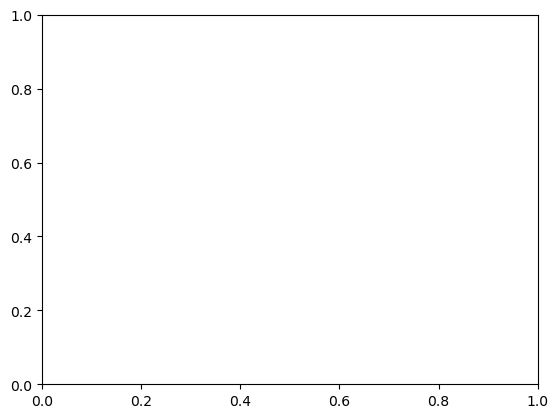

In [58]:
specific_track, lat, lon, SST, flu = zf.track_selector('20220203', zodiac_track_data, excludenans=True, excludemdr=True)

plt.scatter(lon, lat, SST)

In [52]:
len(lat)

6229

In [ ]:
# Arrays to fill #
failed_dates   = [] # List of dates Zodiac did not leave
zero_grad      = [] # indices of where a sst local max and min resides 

# Arrays for Data Analysis # 
filament_width = []
symmetry       = []

# Ensemble of ALL filaments #
filament_ensemble = {}

# Needed values #
compass_range=np.arange(180, 361, 1)
compass_range = np.append(compass_range, compass_range[::-1])

# This master loop is simply to go through each possible date the zodiac went out, and grab corresponding data 
num = 0 # For counting fronts for our ensemble
for d in range(len(dates)):
    try: 
        # FUNCTION WILL GRAB DICTIONARY WITH CORREPSONDING DATE AND REMOVE NANS AS WELL AS ENSURE DATA IS IN DEFINED BOUNDS OF SMB - EXCLUDING MARINA
        specific_track, lat, lon, SST, flu = zf.track_selector(dates[d], zodiac_track_data, excludenans=False, excludemdr=True)
        # Data Processing, Filtering, & Gradients for SST #
        dist_processed, sst_processed = zf.data_processing(lat, lon, SST, 10)
        grad_dist_sst, grad_sst, lat_sst, lon_sst, sst_filtered, dist_filtered = \
        zf.running_avg_filter(window_size, lat, lon, sst_processed, dist_processed)
        # Data Processing, Filtering, & Gradients for Flu #
        dist_processed, flu_processed = zf.data_processing(lat, lon, flu, 10)
        grad_dist_flu, grad_flu, grad_lat_flu, grad_lon_flu, flu_filtered, dist_filtered = \
        zf.running_avg_filter(window_size, lat, lon, flu_processed, dist_processed)

        # Get final details on cruise path - Bearing (Direction of boat)
        bearing = np.around(zf.bearing(lat_sst, lon_sst), 2)
        # split this into components (vector form)
        lon_comp = 1*np.sin(np.around(bearing, 0)*(np.pi/180))
        lat_comp = 1*np.cos(np.around(bearing, 0)*(np.pi/180))
                        
        # Find the local SST minimum and maximums #
        sst_loc_max, _ = find_peaks(sst_filtered, height=0) # READ ABOUT FIND PEAKS ####
        sst_loc_min, _ = find_peaks(-1*sst_filtered, height = -30)
        zero_grad = np.concatenate((sst_loc_max, sst_loc_min))
        # Brefily ensure they are ordered, as the minumums and maximum indices are appended out of order (not along track...)
        for i in range(0, len(zero_grad)):
            for j in range(i+1, len(zero_grad)):
                if(zero_grad[i] > zero_grad[j]):
                    temp = zero_grad[i];
                    zero_grad[i] = zero_grad[j];
                    zero_grad[j] = temp;
                    
        # With our organized array of local maximum and minimum indices, we begin selecting individual segments
        start = 0 # Begin at 0th index
        for i in range(len(zero_grad)-1):    
            # Filament #
            end = start+1 # Index to next one over 
            index1, index2 = zero_grad[start], zero_grad[end] # index 1 and 2 are now the indices that define 1/2 a segment 
            start = end # Move start over 1 to grab next segment in loop

            #print(f'Checking for Filament')
            
            # Check for Filament #
            # Ensure that we start with a dip
            if sst_filtered[index1] > sst_filtered[index2]:
                # If true we become concerned in other portion, hence index 3, which is the peak following our central minima
                index3 = zero_grad[end+1]
                    
                # Make sure that somewhere in our filament there is a sufficiently large gradient 
                #if np.max(grad_sst[index1:index2]) >= gradient_thresh and np.max(grad_sst[index2:index3]) >= gradient_thresh:
                if (np.max(grad_sst[index1:index3]) >= gradient_thresh):
                    
                    # Check that we maintain a relatively straight bearing 
                    filament_xcomps, filament_ycomps = lon_comp[index1:index3], lat_comp[index1:index3]
                    X, Y = lon_comp[index1], lat_comp[index1]
                    angles = []
                    for i in range(len(filament_xcomps)-1):
                        try:
                            xi, yi = filament_xcomps[i+1], filament_ycomps[i+1]
                            angles = np.append(angles, (np.arccos(np.dot([X, Y], [xi, yi])/(np.sqrt(X**2 + Y**2)*np.sqrt(xi**2 + yi**2))))*(180/np.pi))
                        except:
                            angles = np.append(angles, np.mean(angles))
                        continue
                    # Ensure that heading does not change more than 90 deg
                    if np.max(angles) < 90:    
                        # Save Filament Data # 
                        filament_distance = dist_filtered[index1:index3]
                        filament_sst      = sst_filtered[index1:index3]
                        filament_flu      = flu_filtered[index1:index3]
                        filament_lat      = lat_sst[index1:index3]
                        filament_lon      = lon_sst[index1:index3]

                        if normalize_ensembles == True:
                        # ORGANIZE DATA #
                        # order from 'small' to 'large' sides 
                            if filament_sst[-1] < filament_sst[0]:
                                filament_sst = filament_sst[::-1]
                                filament_flu = filament_flu[::-1]
                            symm_test = (filament_sst[0]-np.min(filament_sst))/(filament_sst[-1]-np.min(filament_sst))
                        else: 
                            if filament_sst[-1] < filament_sst[0]:
                                symm_test = (filament_sst[-1]-np.min(filament_sst))/(filament_sst[0]-np.min(filament_sst))
                            else:
                                symm_test = (filament_sst[0]-np.min(filament_sst))/(filament_sst[-1]-np.min(filament_sst))
                                
                        # FINAL CHECKS - SYMMETRY AND DISCONTINUITIES #
                        if (symm_test) >= .30:
                            if len(np.diff(filament_distance)[np.diff(filament_distance) > 0.05]) == 0:

                                # Normalize distances  
                                index = np.where(filament_sst == np.min(filament_sst))
                                min_index = index[0]
                                equal_dist = filament_distance - filament_distance[min_index-1] # Equidistant View of Front from minima
                                filament_width = np.append(filament_width, abs(equal_dist[0])+abs(equal_dist[-1])) # Single value for size of front
        
                                # SST # 
                                equal_sst = filament_sst - filament_sst[min_index]
                                #prcnt_sst = ((filament_sst - filament_sst[0])/(filament_sst[-1] - filament_sst[0]))*100
                                fil_symm = (filament_sst[0]-np.min(filament_sst))/(filament_sst[-1]-np.min(filament_sst))
                                symmetry = np.append(symmetry, fil_symm)
    
                                # Positions of Filament (minima) #
                                min_lat = filament_lat[min_index]
                                min_lon = filament_lon[min_index]
                                # Orientation of Filament #
                                # x_comp  = filament_ycomps[min_index]
                                # y_comp  = -1*filament_xcomps[min_index]
                                x_comp  = np.mean(filament_ycomps)
                                y_comp  = np.mean(-1*filament_xcomps)
                                
                                # Counter #
                                fil_number = num+1
                                num = fil_number
                                print(f'Filament {fil_number} Detected on {dates[d]}', end = '\r')
        
                                # Save to Dictionary # 
                                # Origin Based for Ensemble 
                                cruises = {'Date': (dates[d]), \
                                           # Filament Imaging
                                           'Equi-Dist': (equal_dist), 'Equi-SST': (equal_sst), \
                                           # General Data
                                           'Distance': (filament_distance), 'SST': (filament_sst), 'Flu': (filament_flu), \
                                           'Latitude': (filament_lat), 'Longitude': (filament_lon), \
                                           'Min-Lat': (min_lat), 'Min-Lon': (min_lon), \
                                           'x-comp': (x_comp), 'y-comp': (y_comp), \
                                           'Symmetry': (fil_symm)}
                                filament_ensemble[str(fil_number)] = cruises

                    
    except:
        failed_dates = np.append(failed_dates, dates[d])
    continue 

#### Fronts

In [ ]:
def is_subset(arr1, arr2, m, n):

    # Iterate over each element in the second array
    for i in range(n):
        found = False

        # Check if the element exists in the first array
        for j in range(m):
            if arr2[i] == arr1[j]:
                found = True
                break

        # If any element is not found, return false
        if not found:
            return False

    # If all elements are found, return true
    return True


In [ ]:
# Arrays to fill #
failed_dates = [] # List of dates Zodiac did not leave
zero_grad = [] # indices of where a sst local max and min resides 

# Arrays for Data Analysis # 
front_width = []
sst_change = []

# Ensemble of ALL Fronts #
front_ensemble = {}

# This master loop is simply to go through each possible date the zodiac went out, and grab corresponding data 
num = 0 # For counting fronts for our ensemble
for d in range(len(dates)):
    try: 
        # FUNCTION WILL GRAB DICTIONARY WITH CORREPSONDING DATE AND REMOVE NANS AS WELL AS ENSURE DATA IS IN DEFINED BOUNDS OF SMB - EXCLUDING MARINA
        specific_track, lat, lon, SST, flu = zf.track_selector(dates[d], zodiac_track_data, excludenans=True, excludemdr=True)
        
        # Data Processing, Filtering, & Gradients for SST #
        dist_processed, sst_processed = zf.data_processing(lat, lon, SST, 10)
        grad_dist_sst, grad_sst, lat_sst, lon_sst, sst_filtered, dist_filtered = \
        zf.running_avg_filter(window_size, lat, lon, sst_processed, dist_processed)
        # Data Processing, Filtering, & Gradients for Flu #
        dist_processed, flu_processed = zf.data_processing(lat, lon, flu, 10)
        grad_dist_flu, grad_flu, grad_lat_flu, grad_lon_flu, flu_filtered, dist_filtered = \
        zf.running_avg_filter(window_size, lat, lon, flu_processed, dist_processed)
        
        # Find the local SST minimum and maximums #
        sst_loc_max, _ = find_peaks(sst_filtered, height=0)
        sst_loc_min, _ = find_peaks(-1*sst_filtered, height = -30)
        zero_grad = np.concatenate((sst_loc_max, sst_loc_min))
        # Brefily ensure they are ordered, as the minumums and maximums are concated out of order (not along track...)
        for i in range(0, len(zero_grad)):
            for j in range(i+1, len(zero_grad)):
                if(zero_grad[i] > zero_grad[j]):
                    temp = zero_grad[i];
                    zero_grad[i] = zero_grad[j];
                    zero_grad[j] = temp;
                    
        # With our organized array of local maximum and minimums, we begin selecting individual segments
        start = 0 # Begin at 0th index
        for i in range(len(zero_grad)-1):
            end = start+1 # Index to next one over 
            index1, index2 = zero_grad[start], zero_grad[end] # index 1 and 2 are now the indices that define one segment 
            start = end # Move start over 1 to grab next segment in loop
            
            # With an individual segment selected, we grab its gradients and check whether it is a front via boolean # 
            nonzero_gradients = grad_sst[index1:index2]
            if np.max(nonzero_gradients) >= gradient_thresh: # since the front is of a large degree change, save its distance
                
                # Here, it has been proven that our segment exceeds a set threshold, and is indeed a front. Therefore grab other variables  
                nonzero_gradient_distances = grad_dist_sst[index1:index2] # Coordinates for gradient locations 
                frontal_distance = dist_filtered[index1:index2] # coordinates for sst and flu locations 
                frontal_sst = sst_filtered[index1:index2]
                frontal_flu = flu_filtered[index1:index2]
                # Record the position too, using boat positions 
                front_lat = lat_sst[index1:index2]
                front_lon = lon_sst[index1:index2]
                
                # Ensure that this front is not a part of a filament
                filament = 0
                for f in range(len(filament_ensemble)):
                    if (filament_ensemble[str(f+1)]['Date'] == dates[d]):
                        fil_lat = filament_ensemble[str(f+1)]['Latitude']
                        fil_lon = filament_ensemble[str(f+1)]['Longitude']
                        if is_subset(fil_lat, front_lat, len(fil_lat), len(front_lat)) and is_subset(fil_lon, front_lon, len(fil_lon), len(front_lon)):
                            #print(f'{dates[d]} number {(f)} is a filament')
                            filament = 1
                            break
                if filament != 1:
                    
                    # We have a front and relevant information about that front. Before we proceed, lets make sure this front is 'legit' #
                    # in some cases, data outages may creates large gaps in data, placing two different water readings next to each other 
                    if len(np.diff(frontal_distance)[np.diff(frontal_distance) > 0.05]) == 0:
                        # If there is not a large discontinuity across the bay, ensure that the removal of the marina has not created its own gap
                        mdr_front_lat = front_lat[((front_lon > -118.481) & (front_lon < -118.418)) & ((front_lat < 33.984) & (front_lat > 33.936))]
                        mdr_front_lon = front_lon[((front_lon > -118.481) & (front_lon < -118.418)) & ((front_lat < 33.984) & (front_lat > 33.936))]
                        # if there is data right outside of marina we exclude these fronts from the data, such that the loop does not conitnue
                        if (len(mdr_front_lat) == 0 ) and (len(mdr_front_lon) == 0):
                            
                            # Organize from cold to warm water, if not already, such that all fronts are interpreted along one direction #
                            if normalize_ensembles == True:
                                if frontal_sst[-1] < frontal_sst[0]:
                                    frontal_sst = frontal_sst[::-1]
                                    frontal_flu = frontal_flu[::-1]
                                # Distances direction is irrelevant, start with collecting normalized data 
                                
                            # Distances 
                            mid_index = int(len(frontal_distance)/2)
                            equal_dist = frontal_distance - frontal_distance[mid_index-1] # Equidistant View of Front, for common origin in ensemble
                            prcnt_dist = ((frontal_distance - frontal_distance[0])/(frontal_distance[-1] - frontal_distance[0]))*100 # Front length in %
                            front_width = np.append(front_width, abs(equal_dist[0])+abs(equal_dist[-1])) # Single value for size of front
                        
                            # SST 
                            equal_sst = frontal_sst - frontal_sst[mid_index]
                            prcnt_sst = ((frontal_sst - frontal_sst[0])/(frontal_sst[-1] - frontal_sst[0]))*100
                            sst_change = np.append(sst_change, frontal_sst[-1]-frontal_sst[0]) 
    
                            # Counter #
                            front_number = num+1
                            num = front_number
                            print(f'Front {front_number} Detected on {dates[d]}', end = '\r')
                            
                            
                            # Save to Dictionary # 
                                      # Origin Based for Ensemble 
                            cruises = {'Date': (dates[d]), \
                                       # Frontal Imaging
                                       'Equi-Dist': (equal_dist), 'Equi-SST': (equal_sst), \
                                       # General Data
                                       'Distance': (frontal_distance), 'SST': (frontal_sst), 'Flu': (frontal_flu)}
                            front_ensemble[str(front_number)] = cruises
        
        
    except:
        failed_dates = np.append(failed_dates, dates[d])
    continue 

### Plots

#### Individual Plots

In [ ]:
if individual_cruise_ensemble == True:

    fig, ax = plt.subplots(1, figsize = (20,10))
    #date = '010115'
    #res = 70
    
    plt.plot(dist_filtered, sst_filtered)
    bearing = np.around(zf.bearing(lat_sst, lon_sst), 2)
    # split this into components (vector form)
    lon_comp = 1*np.sin(np.around(bearing, 0)*(np.pi/180))
    lat_comp = 1*np.cos(np.around(bearing, 0)*(np.pi/180))
    #plt.quiver(dist_filtered[::res], np.mean(sst_filtered)*np.ones(len(dist_filtered))[::res], lon_comp[::res], lat_comp[::res], \
           #headwidth = .1)
    #plt.scatter(dist_filtered, np.min(sst_filtered)*np.ones(len(dist_filtered)) - .01*np.min(sst_filtered), c = bearing, \
                #s = 1000, marker='s', cmap='twilight_shifted')

    x = dist_filtered
    z = bearing 
    y = np.min(sst_filtered)*np.ones(len(dist_filtered)) - .01*np.min(sst_filtered)
    
    # Sort the x values and corresponding z values
    sorted_indices = np.argsort(x)
    x_sorted = x[sorted_indices]
    z_sorted = z[sorted_indices]
    
    # Create segments for the line
    points = np.array([x_sorted, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    # Normalize colors for the colormap
    norm = plt.Normalize(z_sorted.min(), z_sorted.max())
    cmap = plt.cm.twilight_shifted # Choose a colormap
    
    # Create a LineCollection
    line_collection = LineCollection(segments, cmap=cmap, norm=norm)
    line_collection.set_array(z_sorted[:-1])  # Set colors based on z values
    line_collection.set_linewidth(30)  # Set thickness of the line

    ax.add_collection(line_collection)
        
    for i in range(len(filament_ensemble)):
        x=filament_ensemble[str(i+1)]['Distance']
        y=filament_ensemble[str(i+1)]['SST']    
        plt.plot(x, y, '-g')
    # for i in range(len(front_ensemble)):
    #     x=front_ensemble[str(i+1)]['Distance']
    #     y=front_ensemble[str(i+1)]['SST']
    #     plt.plot(x, y, '-r')
    
    #plt.colorbar().set_label('Boat Heading - North = 0/360$^{\circ}$', fontsize = fs_tick)
    # Add a colorbar
    cbar = fig.colorbar(line_collection, ax=ax, orientation='vertical')
    cbar.set_label('Boat Heading - North = 0/360$^{\circ}$', fontsize = fs_tick)
    
    # Plot discontinuities 
    dist_track = []
    if len(np.diff(dist_filtered)[np.diff(dist_filtered) > 0.05]) != 0:
        breaks = np.where(np.diff(dist_filtered) > 0.05)[0]
        start = 0
        for b in range(len(breaks)):
            dist_track.append(dist_filtered[start:breaks[b]+1])
            start = breaks[b]+1
            if (b+1) == len(breaks):
                dist_track.append(dist_filtered[start::])
    for n in range(len(dist_track)): 
        if (n > 0) and (n < len(dist_track)):
            plt.axvspan(dist_track[n-1][-1], dist_track[n][0], color = 'gray', zorder = 0)

    green_patch = mpatches.Patch(color='green', label='Filament') 
    red_patch = mpatches.Patch(color='red', label='Front')
    gray_patch = mpatches.Patch(color='gray', label='Discontinuity')
    plt.legend(handles=[green_patch, red_patch, gray_patch], loc='upper right', fontsize = fs_tick)
    
    plt.xticks(fontsize=fs_tick)
    plt.yticks(fontsize=fs_tick)
        
    plt.title('Filaments versus Fronts in SST Track', fontsize=fs_title)
    plt.xlabel('Distance [km]', fontsize = fs_label)
    plt.ylabel('SST [$^{\circ}C$]', fontsize = fs_label)
    
    plt.tight_layout()

if saveplots == True:
    plt.savefig('individual_cruise.png')

#### Ensembles

In [ ]:
fil_ens_fig = plt.figure(1, (20, 10)) 
date = []

for i in range(len(filament_ensemble)):
    sum = (i+1)
    x = filament_ensemble[str(i+1)]['Equi-Dist']
    y = filament_ensemble[str(i+1)]['Equi-SST']
    date = np.append(date, filament_ensemble[str(i+1)]['Date'])
    
    # if showFlu == True:
    #     f = filament_ensemble[str(i)]['Flu']
    #     plt.plot(x, f)

    if max(y) <= .5:
        plt.plot(x, y, color = 'green', zorder=4)
    elif max(y) <= 1.0:
        plt.plot(x, y, color = 'blue', zorder=3)
    elif max(y) <= 1.5:
        plt.plot(x, y, color = 'orange', zorder=2)
    else:
        plt.plot(x, y, color = 'red', zorder=1)

    plt.xlabel('Distance from Minimum SST [km]', fontsize=fs_label)
    plt.ylabel('$\Delta$SST from Minimum [$^{\circ}C$]', fontsize=fs_label)
    plt.title(f'Ensemble of Filaments - {sum} Total', fontsize=fs_title)

dates = np.unique(date)

plt.xticks(fontsize=fs_tick), plt.yticks(fontsize=fs_tick)

green_patch = mpatches.Patch(color='green', label='$\Delta_{max}$ $\leq$ .5') 
blue_patch = mpatches.Patch(color='blue', label='.5 < $\Delta_{max}$ $\leq$ 1.0')
orange_patch = mpatches.Patch(color='orange', label='1.0 < $\Delta_{max}$ $\leq$ 1.5')
red_patch = mpatches.Patch(color='red', label='$\Delta_{max}$ > 1.5')
plt.legend(handles=[green_patch, blue_patch, orange_patch, red_patch], fontsize = 20)

plt.axhline(y=0, linestyle = '--', color = 'k', alpha = .5)
plt.axvline(x=0, linestyle = '--', color = 'k', alpha = .5)

plt.tight_layout()

print(f'Cruise Dates: \n {dates}')

# if saveplots == True:
#     plt.savefig('all_filament_ensemble.png')

In [ ]:
np.mean(fil)

In [ ]:
front_ens_fig = plt.figure(1, (20, 10)) 
date = []
legend_settings = 'sst_change'

sum = 0
for i in range(len(front_ensemble)):
    x = front_ensemble[str(i+1)]['Equi-Dist']
    y = front_ensemble[str(i+1)]['Equi-SST']
    date = np.append(date, front_ensemble[str(i+1)]['Date'])
    if front_width[i] <= .5:
        sum = sum + 1
        plt.plot(x, y, color = 'green', zorder=4)
    elif front_width[i] <= 1.0:
        sum = sum + 1
        plt.plot(x, y, color = 'blue', zorder=3)
    elif front_width[i] <= 1.5:
        sum = sum + 1
        plt.plot(x, y, color = 'orange', zorder=2)

dates = np.unique(date)

green_patch = mpatches.Patch(color='green', label='$Width \leq .5km$') 
blue_patch = mpatches.Patch(color='blue', label='.5km < $Width$ $\leq$ 1.0km')
orange_patch = mpatches.Patch(color='orange', label='1.0km < $Width$ $\leq$ 1.5km')

    
plt.legend(handles=[green_patch, blue_patch, orange_patch], fontsize = 20)

plt.xticks(fontsize=fs_tick), plt.yticks(fontsize=fs_tick)
                
plt.xlabel('Distance from Midpoint [km]', fontsize=fs_label)
plt.ylabel('$\Delta$SST from Midpoint [$^{\circ}C$]', fontsize=fs_label)
plt.title(f'Ensemble of Fronts - {sum} Total', fontsize=fs_title)

plt.axhline(y=0, linestyle = '--', color = 'k', alpha = .5)
plt.axvline(x=0, linestyle = '--', color = 'k', alpha = .5)

plt.xlim(-.75, .75)
plt.ylim(-3, 3)

plt.tight_layout()

if saveplots == True:
    plt.savefig('all_fronts_ensemble.png')

print(f'Cruise Dates: \n {dates}')

In [ ]:
front_ens_fig = plt.figure(1, (20, 10)) 
date = []
legend_settings = 'sst_change'

sum = 0
for i in range(len(front_ensemble)):
    x = front_ensemble[str(i+1)]['Equi-Dist']
    y = front_ensemble[str(i+1)]['Equi-SST']
    if front_width[i] > 5:
        continue
    date = np.append(date, front_ensemble[str(i+1)]['Date'])
    sum = i + 1
    if legend_settings == 'width':
        if front_width[i] <= .5:
            plt.plot(x, y, color = 'green', zorder=4)
        elif front_width[i] <= 1.0:
            plt.plot(x, y, color = 'blue', zorder=3)
        elif front_width[i] <= 1.5:
            plt.plot(x, y, color = 'orange', zorder=2)
        else:
            plt.plot(x, y, color = 'red', zorder=1)
    else:
        if sst_change[i] <= .5:
            plt.plot(x, y, color = 'green', zorder=4)
        elif sst_change[i] <= 1:
            plt.plot(x, y, color = 'blue', zorder=3)
        elif sst_change[i] <= 1.5:
            plt.plot(x, y, color = 'orange', zorder=2)
        else:
            plt.plot(x, y, color = 'red', zorder=1)

dates = np.unique(date)

if legend_settings == 'width':
    green_patch = mpatches.Patch(color='green', label='$Width \leq .5km$') 
    blue_patch = mpatches.Patch(color='blue', label='.5km < $Width$ $\leq$ 1.0km')
    orange_patch = mpatches.Patch(color='orange', label='1.0km < $Width$ $\leq$ 1.5km')
    red_patch = mpatches.Patch(color='red', label='$Width$ > 1.5km')
    plt.legend(handles=[green_patch, blue_patch, orange_patch, red_patch], fontsize = 20)
else:
    green_patch = mpatches.Patch(color='green', label='$\Delta_{sst} \leq .5^{\circ}C$') 
    blue_patch = mpatches.Patch(color='blue', label='$.5^{\circ}C$ < $\Delta_{sst}$ $\leq$ 1.0$^{\circ}C$')
    orange_patch = mpatches.Patch(color='orange', label='$1.0^{\circ}C$ < $\Delta_{sst}$ $\leq$ $1.5^{\circ}C$')
    red_patch = mpatches.Patch(color='red', label='$\Delta_{sst}$ > $1.5^{\circ}C$')
    plt.legend(handles=[green_patch, blue_patch, orange_patch, red_patch], fontsize = 20)

plt.xticks(fontsize=fs_tick), plt.yticks(fontsize=fs_tick)
                
plt.xlabel('Distance from Midpoint [km]', fontsize=fs_label)
plt.ylabel('$\Delta$SST from Midpoint [$^{\circ}C$]', fontsize=fs_label)
plt.title(f'Ensemble of Fronts - {sum} Total', fontsize=fs_title)

plt.axhline(y=0, linestyle = '--', color = 'k', alpha = .5)
plt.axvline(x=0, linestyle = '--', color = 'k', alpha = .5)

plt.xlim(-2.75, 2.75)
plt.ylim(-3, 3)

plt.tight_layout()

print(f'Cruise Dates: \n {dates}')

if saveplots == True:
    plt.savefig('all_fronts_ensemble.png')

#### Fluorometry

In [ ]:
if individual_cruise_ensemble == True:

    from statistics import covariance
    fig, ax1 = plt.subplots(1, figsize = (20,10))
    ax2 = ax1.twinx()
    #date = '010115'
    #res = 70

    cov_fil,  r_fil  = [], []
    cov_data, r_data = [], []

    fil_sst, fil_flu = [], []
    non_sst, non_flu = [], [] 
    
    ax1.plot(dist_filtered, sst_filtered, color = 'lightcoral')
    ax2.plot(dist_filtered, flu_filtered, color = 'seagreen')

    all_fil_din = []
    for i in range(len(filament_ensemble)):
        x=filament_ensemble[str(i+1)]['Distance']
        y=filament_ensemble[str(i+1)]['SST']
        z=filament_ensemble[str(i+1)]['Flu']

        # current fil
        cov_fil = np.append(cov_fil, np.abs(covariance(y,z))/(np.std(y)*np.std(z)))
        r_fil   = np.append(r_fil,   np.abs(ss.pearsonr(y,z)[0]))
        fil_sst = np.append(fil_sst, y)
        fil_flu = np.append(fil_flu, z)
        
        ax1.axvspan(x[0], x[-1], color = 'gray', alpha = .1, zorder = 0)
        ax1.axvline(x[0], color ='k', linestyle = '--', alpha = .7)
        ax1.axvline(x[-1], color = 'k', linestyle = '--', alpha = .7)

        # Not in fil
        fil_dis_str = int(np.where(dist_filtered == x[0])[0][0])
        fil_dis_end = int(np.where(dist_filtered == x[-1])[0][0])
        if i == 0:
            #ax1.axvspan(0, dist_filtered[fil_dis_str], color = 'blue', alpha = .1, zorder = 0)
            nx = dist_filtered[0:fil_dis_str]
            ny = sst_filtered[0:fil_dis_str]
            nz = flu_filtered[0:fil_dis_str]
        elif i == (len(filament_ensemble)-1):
            #ax1.axvspan(dist_filtered[fil_dis_end], dist_filtered[-1], color = 'blue', alpha = .1, zorder = 0)
            nx = dist_filtered[fil_dis_end+1:-1]
            ny = sst_filtered[fil_dis_end+1:-1]
            nz = flu_filtered[fil_dis_end+1:-1]
        else:
            d=filament_ensemble[str(i)]['Distance']
            old_dis_end = int(np.where(dist_filtered == d[-1])[0][0])
            #ax1.axvspan(dist_filtered[old_dis_end], dist_filtered[fil_dis_str], color = 'blue', alpha = .1, zorder = 0)
            nx = dist_filtered[old_dis_end+1:fil_dis_str-1]
            ny = sst_filtered[old_dis_end+1:fil_dis_str-1]
            nz = flu_filtered[old_dis_end+1:fil_dis_str-1]

        non_sst = np.append(non_sst, ny)
        non_flu = np.append(non_flu, nz)
        
        cov_data = np.append(cov_data, np.abs(covariance(ny,nz))/(np.std(ny)*np.std(nz)))
        r_data   = np.append(r_data,   np.abs(ss.pearsonr(ny,nz)[0]))
        
        # ax1.plot(nx, ny, color = 'm')
        # ax2.plot(nx, nz, color = 'm')

    for i in range(len(front_ensemble)):
        x=front_ensemble[str(i+1)]['Distance']
        y=front_ensemble[str(i+1)]['SST']

    # r vals
    # cov_filament  = np.mean(cov_fil)
    # r_filament    = np.mean(r_fil)
    # cov_nofill = np.mean(cov_data)
    # r_nofill   = np.mean(r_data)

    cov_filament  = np.abs(covariance(fil_sst,fil_flu))/(np.std(fil_sst)*np.std(fil_flu))
    r_filament    = np.abs(ss.pearsonr(fil_sst,fil_flu)[0])
    cov_nofill = np.abs(covariance(non_sst,non_flu))/(np.std(non_sst)*np.std(non_flu))
    r_nofill   = np.abs(ss.pearsonr(non_sst,non_flu)[0])
    
    print(cov_filament, r_filament)
    print(cov_nofill, r_nofill)
    
    # Plot discontinuities 
    dist_track = []
    if len(np.diff(dist_filtered)[np.diff(dist_filtered) > 0.05]) != 0:
        breaks = np.where(np.diff(dist_filtered) > 0.05)[0]
        start = 0
        for b in range(len(breaks)):
            dist_track.append(dist_filtered[start:breaks[b]+1])
            start = breaks[b]+1
            if (b+1) == len(breaks):
                dist_track.append(dist_filtered[start::])
    for n in range(len(dist_track)): 
        if (n > 0) and (n < len(dist_track)):
            plt.axvspan(dist_track[n-1][-1], dist_track[n][0], color = 'gray', zorder = 0)

    
    gray_patch = mpatches.Patch(color='gray', label='Span of Filament')
    leg = plt.legend(handles=[ gray_patch], loc='upper right', fontsize = fs_tick)
    frame = leg.get_frame()
    frame.set_linewidth(1)
    frame.set_edgecolor('black')
    
    # ax1.set_xticks(fontsize=fs_tick)
    # ax1.set_yticks(fontsize=fs_tick)
    # ax2.set_yticks(fontsize=fs_tick)

    ax1.tick_params(axis='x', labelsize=fs_tick)
    ax1.tick_params(axis='y', labelsize=fs_tick, colors='lightcoral')
    ax2.tick_params(axis='y', labelsize=fs_tick, colors='seagreen')

    ax1.set_title('Variance in Fluorescence with Temperature - August 17$^{th}$, 2020', fontsize=fs_title)
    ax1.set_xlabel('Distance (km)', fontsize = fs_label)
    ax1.set_ylabel('SST ($^{\circ}$C)', fontsize = fs_label, color = 'lightcoral')
    ax2.set_ylabel('Fluorescence (counts)', fontsize = fs_label, color = 'seagreen')

    ax1.text(0, 21.5, f'$r_{{filament}}: {r_filament:.3f}$', fontsize=fs_tick)
    ax1.text(0,21.3, f'$r_{{nofil.}}   :{r_nofill:.3f}$', fontsize=fs_tick)

    
    plt.tight_layout()

if saveplots == True:
    plt.savefig('flu_cruisetrack.png')

In [ ]:
np.max(zf.gradient(dist_filtered, sst_filtered, lat_sst, lon_sst)[1])

In [ ]:
np.max(sst_filtered)-np.min(sst_filtered)

In [ ]:
dist_filtered[-1]

In [ ]:
fil_ens_fig, ax1 = plt.subplots(1, figsize = (20, 10)) 
date = []
ax2 = ax1.twinx()
showFlu = True

for i in range(len(filament_ensemble)):
    sum = (i+1)
    x = filament_ensemble[str(i+1)]['Equi-Dist']
    y = filament_ensemble[str(i+1)]['Equi-SST']
    date = np.append(date, filament_ensemble[str(i+1)]['Date'])
    if showFlu == True:
        f = filament_ensemble[str(i+1)]['Flu']
        f_norm = ((f - np.min(f))/(np.max(f)-np.min(f)))*100

    ax1.plot(x, y, 'lightcoral', alpha = .8)
    ax2.plot(x, f_norm, 'seagreen', alpha = .4)
    ax1.set_zorder(ax2.get_zorder()+1)
    ax1.patch.set_visible(False)

ax1.set_xlabel('Distance from Minimum SST [km]', fontsize=fs_label)
ax1.set_ylabel('$\Delta$SST from Minimum [$^{\circ}C$]', fontsize=fs_label)
ax1.set_title(f'Ensemble of Filaments with Fluorometry - {sum} Total', fontsize=fs_title)

dates = np.unique(date)

#plt.xticks(fontsize=fs_tick), plt.yticks(fontsize=fs_tick)

green_patch = mpatches.Patch(color='green', label='Fluorescence')
red_patch = mpatches.Patch(color='red', label='SST')
ax1.legend(handles=[green_patch, red_patch], fontsize = 20)

# plt.axhline(y=0, linestyle = '--', color = 'k', alpha = .5)
# plt.axvline(x=0, linestyle = '--', color = 'k', alpha = .5)

# plt.tight_layout()

print(f'Cruise Dates: \n {dates}')

plt.savefig('filament_flu_ensemble.png')

In [ ]:
fil_ens_fig, ax1 = plt.subplots(1, figsize = (20, 10)) 
date = []
ax2 = ax1.twinx()
showFlu = True

for i in range(len(front_ensemble)):
    sum = (i+1)
    x = front_ensemble[str(i+1)]['Equi-Dist']
    y = front_ensemble[str(i+1)]['Equi-SST']
    if front_width[i] > 5:
        continue
    date = np.append(date, front_ensemble[str(i+1)]['Date'])
    if showFlu == True:
        f = front_ensemble[str(i+1)]['Flu']
        f_norm = ((f - np.min(f))/(np.max(f)-np.min(f)))*100

    ax1.plot(x, y, 'lightcoral', alpha = .8)
    ax2.plot(x, f_norm, 'seagreen', alpha = .4)
    ax1.set_zorder(ax2.get_zorder()+1)
    ax1.patch.set_visible(False)

ax1.set_xlabel('Distance from Midpoint [km]', fontsize=fs_label)
ax1.set_ylabel('$\Delta$SST from Midpoint [$^{\circ}C$]', fontsize=fs_label)
ax1.set_title(f'Ensemble of Fronts with Fluorometry - {sum} Total', fontsize=fs_title)

dates = np.unique(date)

#plt.xticks(fontsize=fs_tick), plt.yticks(fontsize=fs_tick)

green_patch = mpatches.Patch(color='green', label='Fluorescence')
red_patch = mpatches.Patch(color='red', label='SST')
ax1.legend(handles=[green_patch, red_patch], fontsize = 20)

# plt.axhline(y=0, linestyle = '--', color = 'k', alpha = .5)
# plt.axvline(x=0, linestyle = '--', color = 'k', alpha = .5)

# plt.tight_layout()

print(f'Cruise Dates: \n {dates}')

plt.savefig('fronts_flu_ensemble.png')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure and axes
fig, axs = plt.subplots(2, 2, figsize=(14, 8))

titles = ['$Width \leq .5km$', '.5km < $Width$ $\leq$ 1.0km', '1.0km < $Width$ $\leq$ 1.5km', '$Width$ > 1.5km']

for i in range(len(front_ensemble)):
    sum = (i+1)
    x = front_ensemble[str(i+1)]['Equi-Dist']
    y = front_ensemble[str(i+1)]['Equi-SST']
    f = front_ensemble[str(i+1)]['Flu']
    f_norm = ((f - np.min(f))/(np.max(f)-np.min(f)))*100
    if front_width[i] > 5:
        continue
    if front_width[i] <= .5:
        # Subplot 1
        ax1 = axs[0, 0]
        ax1.plot(x, y, color='lightcoral', alpha = .4, zorder = 1)
        ax1.set_ylabel('$\Delta$SST', color='lightcoral')
        ax1.tick_params(axis='y', labelcolor='lightcoral')
        
        ax1_twin = ax1.twinx()
        ax1_twin.plot(x, f_norm, color='seagreen', alpha = .4, zorder = 2)
        ax1_twin.set_ylabel('Fluorometry', color='seagreen')
        ax1_twin.tick_params(axis='y', labelcolor='seagreen')
        ax1.set_title(titles[0])

        ax1.set_xlabel('Distance from Midpoint [km]')
    elif front_width[i] <= 1.0:
        # Subplot 2
        ax2 = axs[0, 1]
        ax2.plot(x, y, color='lightcoral', alpha = .4, zorder = 1)
        ax2.set_ylabel('$\Delta$SST', color='lightcoral')
        ax2.tick_params(axis='y', labelcolor='lightcoral')
        
        ax2_twin = ax2.twinx()
        ax2_twin.plot(x, f_norm, color='seagreen', alpha = .4, zorder = 2)
        ax2_twin.set_ylabel('Fluorometry', color='seagreen')
        ax2_twin.tick_params(axis='y', labelcolor='seagreen')
        ax2.set_title(titles[1])
            
        ax2.set_xlabel('Distance from Midpoint [km]')
    elif front_width[i] <= 1.5:
        # Subplot 3
        ax3 = axs[1, 0]
        ax3.plot(x, y, color='lightcoral', alpha = .4, zorder = 1)
        ax3.set_ylabel('$\Delta$SST', color='lightcoral')
        ax3.tick_params(axis='y', labelcolor='lightcoral')
        
        ax3_twin = ax3.twinx()
        ax3_twin.plot(x, f_norm, color='seagreen', alpha = .4, zorder = 2)
        ax3_twin.set_ylabel('Fluorometry', color='seagreen')
        ax3_twin.tick_params(axis='y', labelcolor='seagreen')
        ax3.set_title(titles[2])

        ax3.set_xlabel('Distance from Midpoint [km]')
    else:
        # Subplot 4
        ax4 = axs[1, 1]
        ax4.plot(x, y, color='lightcoral', alpha = .4, zorder = 1)
        ax4.set_ylabel('$\Delta$SST', color='lightcoral')
        ax4.tick_params(axis='y', labelcolor='lightcoral')
        
        ax4_twin = ax4.twinx()
        ax4_twin.plot(x, f_norm, color='seagreen', alpha = .4, zorder = 2)
        ax4_twin.set_ylabel('Fluorometry', color='seagreen')
        ax4_twin.tick_params(axis='y', labelcolor='seagreen')
        ax4.set_title(titles[3])

        ax4.set_xlabel('Distance from Midpoint [km]')

# Common x-axis label
# for ax in axs.flat:
#     ax.label_outer()  # Only show outer labels

# fig.text(0.5, 0.04, 'X-axis', ha='center')
plt.tight_layout(rect=[0.04, 0.04, 1, 1])
plt.show()

#### Geographic Tracks

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
from netCDF4 import Dataset, num2date

fname = '/home/gstaller/Downloads/crm_socal_1as_vers2.nc'
nc = Dataset(fname)

res = 2

lon, lat = np.array(nc.variables['lon'][::res]), np.array(nc.variables['lat'][::res])
depths = np.array(nc.variables['Band1'][::res, ::res])

lon_min = np.where((lon <= -118.25) & (lon > -118.85))[0][-1]
lon_max = np.where((lon <= -118.25) & (lon > -118.85))[0][0]
lat_min = np.where((lat >= 33.5) & (lat < 34.15))[0][0]
lat_max = np.where((lat >= 33.5) & (lat < 34.15))[0][-1]

depths = depths[lat_min:lat_max, lon_max:lon_min]

lon    = lon[lon_max:lon_min]
lat    = lat[lat_min:lat_max]

# lat = lat[(lat >= lat_min) & (lat < lat_max)]
# lon = lon[(lon > lon_max) & (lon <= lon_min)]

lon, lat = np.meshgrid(lon, lat)

In [ ]:
fil_pos_fig = plt.figure(1, (20,15))
showtracks = False

long_lat_coords = [-118.85, -118.25, 33.7, 34.05]
ax = plt.axes(projection = ccrs.PlateCarree())
ax.set_extent(long_lat_coords)
ax.coastlines()
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)

plt.scatter(lon, lat, c = -1*depths, cmap = 'Blues', norm=matplotlib.colors.LogNorm(vmin=10, vmax=800))
#plt.scatter(lon, lat, c = -1*depths, cmap = 'Blues', vmin = 10, vmax = 400)
 
plt.colorbar(shrink = .6).set_label('Depth [m]', fontsize = 18)

cs = plt.contour(lon, lat, depths, [-800, -600, -400, -200, -100, -50, -25, -10], cmap='Wistia_r', vmin=-10, alpha = .8)
plt.clabel(cs, inline = True, fontsize = 14)

for i in range(len(filament_ensemble)):
    if showtracks == True:
        x = filament_ensemble[str(i+1)]['Longitude']
        y = filament_ensemble[str(i+1)]['Latitude']
        z = filament_ensemble[str(i+1)]['SST']
        plt.scatter(x, y, c = z, s = 1, cmap = 'jet')
    else:
        x = filament_ensemble[str(i+1)]['Min-Lon']
        y = filament_ensemble[str(i+1)]['Min-Lat']
        qx = filament_ensemble[str(i+1)]['x-comp']
        qy = filament_ensemble[str(i+1)]['y-comp']
        sym = filament_ensemble[str(i+1)]['Symmetry']
        if sym < .5:
            plt.quiver(x, y, qx, qy, width = .003, headwidth = .001, color = 'red', pivot = 'middle', zorder = 8)
        elif (sym >= .5) and (sym < .7):     
            plt.quiver(x, y, qx, qy, width = .003, headwidth = .001, color = 'yellow', pivot = 'middle', zorder = 9)
        else:
            plt.quiver(x, y, qx, qy, width = .003, headwidth = .001, color = 'green', pivot = 'middle', zorder = 10)
        plt.plot(x, y, 'ko', markersize = 2, zorder = 11)


plt.xticks(np.linspace(-118.80, -118.30, 5), fontsize=14)
plt.yticks(np.arange(33.75, 34.05, .05), fontsize=14)
#plt.yticks(np.linspace(33.7, 34.0, 5), fontsize=14)

green_patch = mpatches.Patch(color='green', label='$\Delta_{sym}$ $\geq$ .7') 
orange_patch = mpatches.Patch(color='yellow', label='.5 $\leq$ $\Delta_{sym}$ < .7')
red_patch = mpatches.Patch(color='red', label='.3 $\leq$ $\Delta_{sym}$ < .5')
#black_patch = mpatches.Circle(color='black', label='Minimum SST')
plt.legend(handles=[green_patch, orange_patch, red_patch], loc='upper right', fontsize = 18)
        
plt.title('Orientation and Position of Filaments', fontsize=fs_title)
plt.xlabel('Longitude', fontsize = fs_label)
plt.ylabel('Latitude', fontsize = fs_label)

plt.savefig('fil_orientarion.png')

plt.tight_layout()